<a href="https://colab.research.google.com/github/samuel0922/my_ex/blob/main/%5BEX_08%5DFaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [ EX08 ] FaceDetection

In [133]:
# 필요한 라이브러리 불러오기

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib


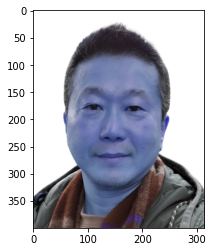

In [95]:
# 데이터 불러오기
mount_path = '/content/drive/MyDrive'
my_image_path = mount_path + '/aiffel/camera_sticker/images/mypic.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

=> openCV는 칼라채널을 RGB가 아닌 GBR로 나타내므로 다르게 읽힘. --> RGB로 변경해 줘야함

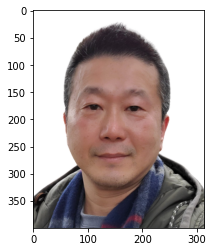

In [96]:
# plt.imshow 이전에 RGB 이미지로 바꿔줌 : cv2.cvtColor()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [97]:
# 얼굴의 위치를 찾아내기 : sliding window를 활용함

# detector를 선언 : dlib.get_fronal_face_detector()
detector_hog = dlib.get_frontal_face_detector()

# bounding box(대상물체를 둘러싼 박스의 좌표) 추출 : detector
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

=> detector_hog(대상이미지, 이미지 피라미드 개수 ) :: dlib.rectangles 타입 객체 반환 :: dlib.rectangle 객체 배열 형태로 됨
* left()
* right()
* top()
* bottom()
* height()
* width()

image pyramid(이미지 피라미드) :이미지를 upsampling 방식 통해 크기를 키우는 것.

rectangles[[(56, 118) (242, 304)]]


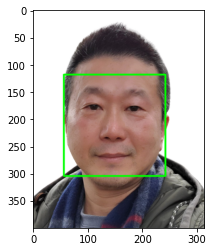

In [98]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 사각형 그리기 : retangle(대상이미지, 좌측상단, 우측하단, 테두리선색상, 테두리선 두께)
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [99]:
# 모델 불러오기

model_path = mount_path +'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
print(model_path)
landmark_predictor = dlib.shape_predictor(model_path)


/content/drive/MyDrive/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat


In [100]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


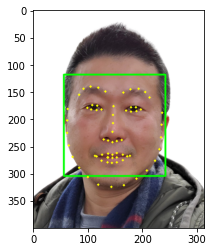

In [101]:
# 랜드마크 영상으로 출력

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## STEP . '스티커' 적용하기
대상이미지에 목적이미지를 갖다붙이는 작업 => 
1. 기준(중심)을 기준으로 높이(거리) x 
2. 목적이미지의 특정 픽셀 n 위에

단, 얼굴 위치, 카메라의 거리에 따라 픽셀 x가 다르기 때문에 비율로 계산해줘야 함

1. 스티커 위치 좌표값 : x = x_nose, y = y_nose - ( height / 2 )
2. 스티커 크기 : width = height = width_bbox

In [102]:
# 좌표 확인

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(145, 223)
(x,y) : (145,130)
(w,h) : (187,187)


In [103]:
# 스티커 이미지 불러들여 적용해 봄
# 수염 이미지를 읽고 윗 단계에서 계산한 크기로 resize

sticker_path = mount_path +'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


In [104]:
# 원본 이미지에 스터커 이미지 추가를 위해 x, y 좌표를 조정함. 
# <= 이미지 시작점은 top-left 좌표임

x = x - w // 2
print ('(x,y) : (%d,%d)'%(x,y))

(x,y) : (52,130)


=> y 값이 음수 ?? 

1. 스티커의 시작점(x, y좌표값)이 얼굴 사진의 영역을 벗어나면 음수로 표현
  * openCV 데이터는 numpy ndarray 형태의 데이터를 사용하므로 음수 인덱스에 접근할 수 없음 -> 음수에 대한 예외 처리를 해 줘야 함.
2. '스티커 시작점 + 스티커 사진'의 크기가 원본 이미지 보다 큰 경우. 즉, 스티커의 사진의 오른쪽이나 아래쪽으로 넘어가는 경우
  -> -y의 크기만큼 스티커를 crop(잘라줌) 하고, top의 x 좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정해 줌


In [105]:
# # 만일 이미지 좌표가 음수인 경우에 대한 예외 처리를 해줌

# if refined_x < 0: 
#     img_sticker = img_sticker[:, -refined_x:]
#     refined_x = 0
# if refined_y < 0:
#     img_sticker = img_sticker[-refined_y:, :]
#     refined_y = 0

# print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

In [106]:
# 원본 이미지에 스티커를 적용함

# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]

img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


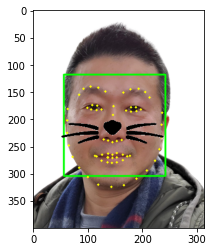

In [107]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

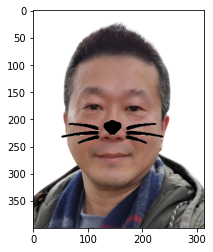

In [108]:
# 바운딩 박스와 landmark를 제거하거 최종 결과만 출력함
# img_show 대신, 지금까지 아껴 두었던 img_bgr을 활용해 봄

sticker_area = img_bgr[y:y +img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_bgr[y:y +img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# STEP . 추가적인 시도
### Try 1. 먼 거리 사진


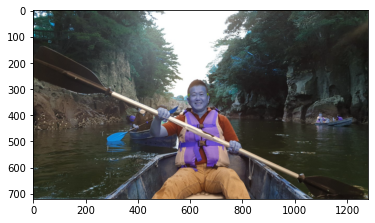

In [148]:
# 데이터 불러오기
mount_path = '/content/drive/MyDrive'
my_image_path = mount_path + '/aiffel/camera_sticker/images/pic_f.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

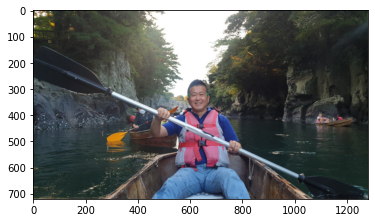

In [149]:
# plt.imshow 이전에 RGB 이미지로 바꿔줌 : cv2.cvtColor()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [150]:
# 얼굴의 위치를 찾아내기 : sliding window를 활용함

# detector를 선언 : dlib.get_fronal_face_detector()
detector_hog = dlib.get_frontal_face_detector()

# bounding box(대상물체를 둘러싼 박스의 좌표) 추출 : detector
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(594, 304) (668, 378)]]


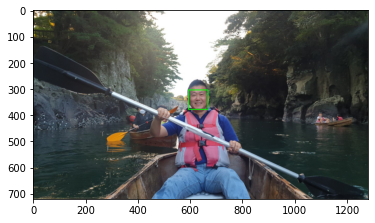

In [151]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 사각형 그리기 : retangle(대상이미지, 좌측상단, 우측하단, 테두리선색상, 테두리선 두께)
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [152]:
# 모델 불러오기

model_path = mount_path +'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
print(model_path)
landmark_predictor = dlib.shape_predictor(model_path)


/content/drive/MyDrive/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat


In [153]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


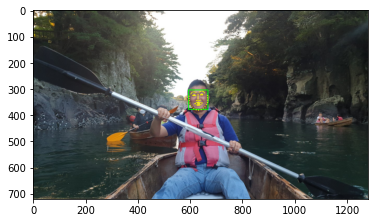

In [154]:
# 랜드마크 영상으로 출력

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [155]:
# 좌표 확인

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(630, 339)
(x,y) : (630,302)
(w,h) : (75,75)


In [156]:
# 스티커 이미지 불러들여 적용해 봄
# 수염 이미지를 읽고 윗 단계에서 계산한 크기로 resize

sticker_path = mount_path +'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(75, 75, 3)


In [157]:
# 원본 이미지에 스터커 이미지 추가를 위해 x, y 좌표를 조정함. 
# <= 이미지 시작점은 top-left 좌표임

x = x - w // 2
print ('(x,y) : (%d,%d)'%(x,y))

(x,y) : (593,302)


In [158]:
# 원본 이미지에 스티커를 적용함

# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]

img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


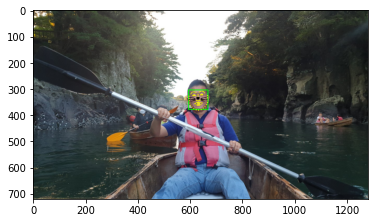

In [159]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

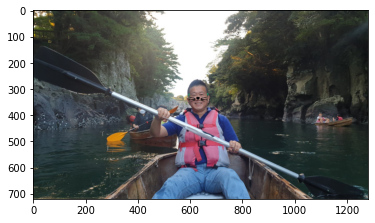

In [160]:
# 바운딩 박스와 landmark를 제거하거 최종 결과만 출력함
# img_show 대신, 지금까지 아껴 두었던 img_bgr을 활용해 봄

sticker_area = img_bgr[y:y +img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_bgr[y:y +img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### Try 2. 누워있는 사진(90도 회전)에 스티커 제대로 붙여보기


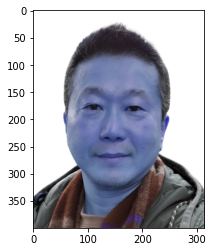

In [109]:
# 데이터 불러오기
mount_path = '/content/drive/MyDrive'

my_image_path = mount_path + '/aiffel/camera_sticker/images/mypic.png'
#my_image_path = mount_path + '/aiffel/camera_sticker/images/mypic_lt45.png'

img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

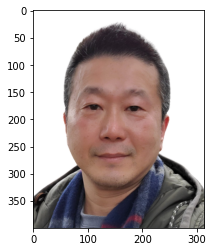

In [110]:
# plt.imshow 이전에 RGB 이미지로 바꿔줌 : cv2.cvtColor()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [123]:

#이미지 회전시키기
width, height = img_rgb.shape[:2] #(1080, 1080)
cp = (img_rgb.shape[1] / 2, img_rgb.shape[0] / 2) #회전 중심축 좌표 설정
print(cp)

img_lt45 = cv2.getRotationMatrix2D(cp, 45, 1) # 센터, 각도, 스케일
img_lt45_m = cv2.warpAffine(img_rgb,img_lt45,(width,height))

(157.5, 200.0)


<function matplotlib.pyplot.show>

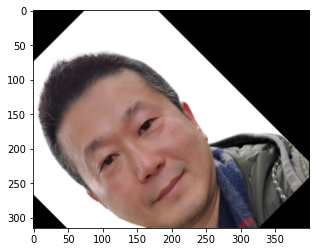

In [124]:
plt.imshow(img_lt45_m)
plt.show

In [125]:
# 얼굴의 위치를 찾아내기 : sliding window를 활용함

# detector를 선언 : dlib.get_fronal_face_detector()
detector_hog = dlib.get_frontal_face_detector()

# bounding box(대상물체를 둘러싼 박스의 좌표) 추출 : detector
dlib_rects = detector_hog(img_lt45_m, 1)   # (image, num of image pyramid)

rectangles[[(56, 118) (242, 304)]]


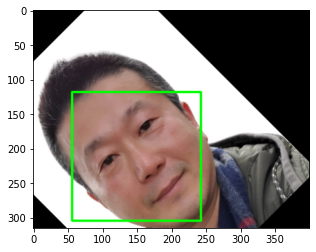

In [126]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 사각형 그리기 : retangle(대상이미지, 좌측상단, 우측하단, 테두리선색상, 테두리선 두께)
    cv2.rectangle(img_lt45_m, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_lt45_m)
plt.show()

In [127]:
# 모델 불러오기

model_path = mount_path +'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
print(model_path)
landmark_predictor = dlib.shape_predictor(model_path)

/content/drive/MyDrive/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat


In [128]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_lt45_m, dlib_rect)
    
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


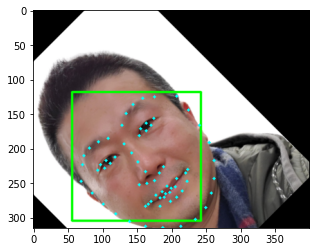

In [129]:
# 랜드마크 영상으로 출력

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_lt45_m, point, 2, (0, 255, 255), -1)

plt.imshow(img_lt45_m)
plt.show()

In [130]:
# 좌표 확인

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(162, 233)
(x,y) : (162,140)
(w,h) : (187,187)


In [131]:
# 스티커 이미지 불러들여 적용해 봄
# 수염 이미지를 읽고 윗 단계에서 계산한 크기로 resize

sticker_path = mount_path +'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


In [120]:
# 원본 이미지에 스터커 이미지 추가를 위해 x, y 좌표를 조정함. 
# <= 이미지 시작점은 top-left 좌표임

x = x - w // 2
print ('(x,y) : (%d,%d)'%(x,y))

(x,y) : (69,140)


In [121]:
# 원본 이미지에 스티커를 적용함

# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_rot_dst[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]

img_rot_dst[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

ValueError: ignored

In [ ]:
plt.imshow(cv2.cvtColor(img_rot_dst, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 바운딩 박스와 landmark를 제거하거 최종 결과만 출력함
# img_show 대신, 지금까지 아껴 두었던 img_bgr을 활용해 봄

sticker_area = img_bgr[y:y +img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_bgr[y:y +img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### [ 루브릭 ]
##### 1. 자기만의 카메라앱 기능 구현을 완수하였다.
-> 원본에 스티커 사진이 정상적으로 합성되었다.

##### 2. 스티커 이미지를 정확한 원본 위치에 반영하였다.

-> 정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.

##### 3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.

-> 얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.

---

### [ 회고 ]

노드에 있는 내용을 위주로 코드 구현해 보았으며, 원본 사진에서 바운딩박스를 표시하고 추출된 랜드마크에서 원하는 위치에 스티커를 합성할 수 있었음.

* 추가작업 1. 원거리에 있는 사진의 경우는 바운딩박스 추출과 랜드마크 추출이 잘 되어 스티커를 원하는 위치에 붙여 합성하는 결과를 확인해 볼 수 있었음.

* 추가작업 2로 원본 사진을 회전시킨 후 스티커를 그에 맞게 회전시켜 붙이는 작업을 추가로 시도하려고 하였음.

  ** 회전후에도 바운딩박스 형성이나 랜드마크 추출은 정상적으로 되는 것을 확인했으나 원본 스티커를 붙여보는 과정에서 오류가 발생한 부분을 처리하지 못하고 시간이 부족하여 제출하게 되었음.

  ** 정면을 보는 사진의 경우, 원본 사진의 좌우회전에 대해서 회전각도를 추출한 뒤 표적좌표의 회전후 좌표를 산출하면, 스티커를 같은 각도만큼 회전하여 갖다 붙이는 방식으로 작업을 수행하면 원하는 결과를 얻을 수 있을 것 같은데,

  ** 사진이 정면이 아닌 측면방향으로 회전한 얼굴 형상인 경우에는, 스티커 이미지를 단순히 각도만 바꿔서 적용할 수는 없을 것이고, 중심축을 기준으로 회전으로 발생하는 이미지의 비율변화를 어떻게 처리할 것인가에 대한 방법을 찾을 필요가 있을 것 같다.
